In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
df=pd.read_csv('bank-additional-full.csv',delimiter=";")
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

### Removing duplicate values

In [4]:
data_dup = df[df.duplicated(keep="last")]

data1 = df.drop_duplicates()
data1.shape

(41176, 21)

### Removing the 'Duration' Column

In [5]:
data=data1.drop('duration',axis=1)
data.shape

(41176, 20)

### One Hot Encoding Categorical Data

In [6]:
nominal=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_new=pd.get_dummies(data,columns=nominal)
data_new['y']=data_new['y'].map({'yes':1,'no':0})
data_new.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0


In [7]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  int64  
 1   campaign                       41176 non-null  int64  
 2   pdays                          41176 non-null  int64  
 3   previous                       41176 non-null  int64  
 4   emp.var.rate                   41176 non-null  float64
 5   cons.price.idx                 41176 non-null  float64
 6   cons.conf.idx                  41176 non-null  float64
 7   euribor3m                      41176 non-null  float64
 8   nr.employed                    41176 non-null  float64
 9   y                              41176 non-null  int64  
 10  job_admin.                     41176 non-null  uint8  
 11  job_blue-collar                41176 non-null  uint8  
 12  job_entrepreneur               41176 non-null 

### Separating the response and explanatory variables

In [8]:
x=data_new.drop('y',axis=1)
y=data_new['y']
x.shape,y.shape

((41176, 62), (41176,))

### Train-Test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=42)

print("X Train:", x_train.shape)
print("X Test:", x_test.shape)
print("Y Train:", y_train.shape)
print("Y Test:", y_test.shape)

X Train: (32940, 62)
X Test: (8236, 62)
Y Train: (32940,)
Y Test: (8236,)


### Random Forest

In [10]:
rf=RandomForestClassifier(random_state=42,n_estimators=100,class_weight="balanced_subsample",max_features=None)
rf.fit(x_train,y_train)
pred=rf.predict(x_test)

### Calibrating Random Forest

In [11]:
clf_isotonic=CalibratedClassifierCV(rf,method='isotonic')
clf_isotonic.fit(x_train,y_train)
y_pred_clf=clf_isotonic.predict_proba(x_test)

### Checking model adequacy

#### Plotting Confusion matrix

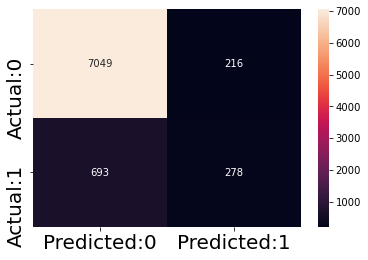

In [12]:
cm= confusion_matrix(y_test, pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [13]:
precision=precision_score(pred,y_test)
recall=recall_score(pred,y_test)
f1=f1_score(pred,y_test)

table=pd.DataFrame({'Metrics':["Precision","Recall","F1 Score"],'Score':[precision,recall,f1]})
table

,Metrics,Score
0,Precision,0.286303
1,Recall,0.562753
2,F1 Score,0.379522


### ROC curve and AUC score

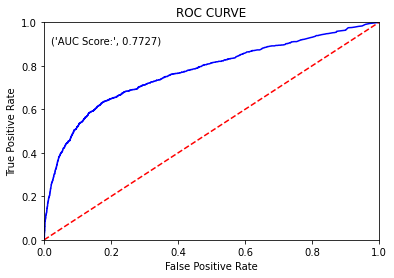

AUC Score obtained : 0.7727


In [23]:
y_pred1=y_pred_clf[:,1]
fpr,tpr,threshold=metrics.roc_curve(y_test,y_pred1)
roc_auc=metrics.auc(fpr,tpr)

plt.title('ROC CURVE')
plt.plot(fpr,tpr,'b',label='AUC=%0.2f' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(x=0.02,y=0.9, s=('AUC Score:',round(metrics.roc_auc_score(y_test, y_pred1),4)))
plt.show()
print("AUC Score obtained :",round(metrics.roc_auc_score(y_test, y_pred1),4))

### Hypertuning the parameters

In [15]:
rf2=RandomForestClassifier(random_state=42,n_jobs=-1,class_weight="balanced_subsample")
para= {
    'max_depth': [4,5,6,7,8],
    'max_features': ['sqrt','log2'],
    'n_estimators': [10,25,30,50,100,200,300, 1000]
}
grid_search=GridSearchCV(estimator=rf2,param_grid=para,cv=4,verbose=2,scoring="f1")
grid_search.fit(x_train,y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
[CV] max_depth=4, max_features=sqrt, n_estimators=10 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. max_depth=4, max_features=sqrt, n_estimators=10, total=  51.0s
[CV] max_depth=4, max_features=sqrt, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.9s remaining:    0.0s


[CV] .. max_depth=4, max_features=sqrt, n_estimators=10, total=   0.5s
[CV] max_depth=4, max_features=sqrt, n_estimators=10 .................
[CV] .. max_depth=4, max_features=sqrt, n_estimators=10, total=   0.7s
[CV] max_depth=4, max_features=sqrt, n_estimators=10 .................
[CV] .. max_depth=4, max_features=sqrt, n_estimators=10, total=   0.7s
[CV] max_depth=4, max_features=sqrt, n_estimators=25 .................
[CV] .. max_depth=4, max_features=sqrt, n_estimators=25, total=   1.0s
[CV] max_depth=4, max_features=sqrt, n_estimators=25 .................
[CV] .. max_depth=4, max_features=sqrt, n_estimators=25, total=   1.5s
[CV] max_depth=4, max_features=sqrt, n_estimators=25 .................
[CV] .. max_depth=4, max_features=sqrt, n_estimators=25, total=   1.1s
[CV] max_depth=4, max_features=sqrt, n_estimators=25 .................
[CV] .. max_depth=4, max_features=sqrt, n_estimators=25, total=   0.9s
[CV] max_depth=4, max_features=sqrt, n_estimators=30 .................
[CV] .

[CV] . max_depth=4, max_features=log2, n_estimators=300, total=   5.3s
[CV] max_depth=4, max_features=log2, n_estimators=1000 ...............
[CV]  max_depth=4, max_features=log2, n_estimators=1000, total=  17.3s
[CV] max_depth=4, max_features=log2, n_estimators=1000 ...............
[CV]  max_depth=4, max_features=log2, n_estimators=1000, total=  18.7s
[CV] max_depth=4, max_features=log2, n_estimators=1000 ...............
[CV]  max_depth=4, max_features=log2, n_estimators=1000, total=  17.0s
[CV] max_depth=4, max_features=log2, n_estimators=1000 ...............
[CV]  max_depth=4, max_features=log2, n_estimators=1000, total=  15.5s
[CV] max_depth=5, max_features=sqrt, n_estimators=10 .................
[CV] .. max_depth=5, max_features=sqrt, n_estimators=10, total=   0.4s
[CV] max_depth=5, max_features=sqrt, n_estimators=10 .................
[CV] .. max_depth=5, max_features=sqrt, n_estimators=10, total=   0.6s
[CV] max_depth=5, max_features=sqrt, n_estimators=10 .................
[CV] .

[CV] . max_depth=5, max_features=log2, n_estimators=200, total=   3.5s
[CV] max_depth=5, max_features=log2, n_estimators=200 ................
[CV] . max_depth=5, max_features=log2, n_estimators=200, total=   3.7s
[CV] max_depth=5, max_features=log2, n_estimators=200 ................
[CV] . max_depth=5, max_features=log2, n_estimators=200, total=   3.5s
[CV] max_depth=5, max_features=log2, n_estimators=300 ................
[CV] . max_depth=5, max_features=log2, n_estimators=300, total=   5.2s
[CV] max_depth=5, max_features=log2, n_estimators=300 ................
[CV] . max_depth=5, max_features=log2, n_estimators=300, total=   4.9s
[CV] max_depth=5, max_features=log2, n_estimators=300 ................
[CV] . max_depth=5, max_features=log2, n_estimators=300, total=   5.6s
[CV] max_depth=5, max_features=log2, n_estimators=300 ................
[CV] . max_depth=5, max_features=log2, n_estimators=300, total=   5.1s
[CV] max_depth=5, max_features=log2, n_estimators=1000 ...............
[CV]  

[CV] .. max_depth=6, max_features=log2, n_estimators=50, total=   1.1s
[CV] max_depth=6, max_features=log2, n_estimators=100 ................
[CV] . max_depth=6, max_features=log2, n_estimators=100, total=   2.3s
[CV] max_depth=6, max_features=log2, n_estimators=100 ................
[CV] . max_depth=6, max_features=log2, n_estimators=100, total=   2.2s
[CV] max_depth=6, max_features=log2, n_estimators=100 ................
[CV] . max_depth=6, max_features=log2, n_estimators=100, total=   2.0s
[CV] max_depth=6, max_features=log2, n_estimators=100 ................
[CV] . max_depth=6, max_features=log2, n_estimators=100, total=   2.2s
[CV] max_depth=6, max_features=log2, n_estimators=200 ................
[CV] . max_depth=6, max_features=log2, n_estimators=200, total=   3.7s
[CV] max_depth=6, max_features=log2, n_estimators=200 ................
[CV] . max_depth=6, max_features=log2, n_estimators=200, total=   3.7s
[CV] max_depth=6, max_features=log2, n_estimators=200 ................
[CV] .

[CV] .. max_depth=7, max_features=log2, n_estimators=30, total=   0.9s
[CV] max_depth=7, max_features=log2, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=30, total=   0.9s
[CV] max_depth=7, max_features=log2, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=30, total=   0.9s
[CV] max_depth=7, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=50, total=   1.2s
[CV] max_depth=7, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=50, total=   1.2s
[CV] max_depth=7, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=50, total=   1.2s
[CV] max_depth=7, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=50, total=   1.2s
[CV] max_depth=7, max_features=log2, n_estimators=100 ................
[CV] .

[CV] .. max_depth=8, max_features=log2, n_estimators=10, total=   0.7s
[CV] max_depth=8, max_features=log2, n_estimators=25 .................
[CV] .. max_depth=8, max_features=log2, n_estimators=25, total=   0.8s
[CV] max_depth=8, max_features=log2, n_estimators=25 .................
[CV] .. max_depth=8, max_features=log2, n_estimators=25, total=   0.7s
[CV] max_depth=8, max_features=log2, n_estimators=25 .................
[CV] .. max_depth=8, max_features=log2, n_estimators=25, total=   0.8s
[CV] max_depth=8, max_features=log2, n_estimators=25 .................
[CV] .. max_depth=8, max_features=log2, n_estimators=25, total=   0.7s
[CV] max_depth=8, max_features=log2, n_estimators=30 .................
[CV] .. max_depth=8, max_features=log2, n_estimators=30, total=   0.9s
[CV] max_depth=8, max_features=log2, n_estimators=30 .................
[CV] .. max_depth=8, max_features=log2, n_estimators=30, total=   0.9s
[CV] max_depth=8, max_features=log2, n_estimators=30 .................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed: 24.0min finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 25, 30, 50, 100, 200, 300, 1000]},
             scoring='f1', verbose=2)

In [16]:
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       max_features='sqrt', n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [17]:
rf_final=RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       max_features='sqrt', n_estimators=1000, n_jobs=-1,
                       random_state=42)
rf_final.fit(x_train,y_train)
pred_final=rf_final.predict(x_test)

### Calibrating hyperparameter tuned model

In [18]:
clf_isotonic_final=CalibratedClassifierCV(rf_final,method='isotonic')
clf_isotonic_final.fit(x_train,y_train)
y_pred_clf_final=clf_isotonic_final.predict_proba(x_test)

### Checking model adequacy

#### Plotting Confusion Matrix

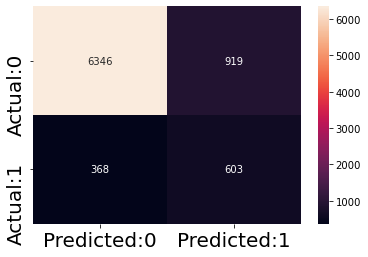

In [19]:
cm= confusion_matrix(y_test, pred_final)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [20]:
precision_final=precision_score(pred_final,y_test)
recall_final=recall_score(pred_final,y_test)
f1_final=f1_score(pred_final,y_test)

table_final=pd.DataFrame({'Metrics':["Precision","Recall","F1 Score"],'Score':[precision_final,recall_final,f1_final]})
table_final

,Metrics,Score
0,Precision,0.621009
1,Recall,0.396189
2,F1 Score,0.483755


### ROC Curve and AUC score of final model

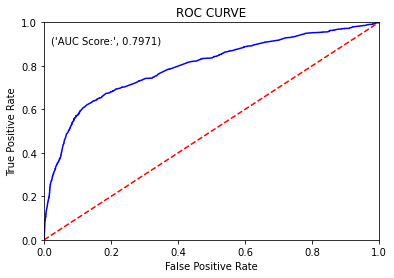

AUC Score obtained : 0.7971


In [22]:
y_pred2=y_pred_clf_final[:,1]
fpr,tpr,threshold=metrics.roc_curve(y_test,y_pred2)
roc_auc=metrics.auc(fpr,tpr)

plt.title('ROC CURVE')
plt.plot(fpr,tpr,'b',label='AUC=%0.2f' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(x=0.02,y=0.9, s=('AUC Score:',round(metrics.roc_auc_score(y_test, y_pred2),4)))
plt.show()
print("AUC Score obtained :",round(metrics.roc_auc_score(y_test, y_pred2),4))